In [1]:
#
# notebook config and settings
#

# regex for query results
search_regex = ".*(Search.*)__(.*)__sz_(\d+)_of_(.+)__q_(\d+)__k_(\d+)__(.+)__([\d\.]+).csv"

# all the dataset sizes
dset_sizes = [ 1000000, 2000000, 5000000, 10000000 ]

# all the query set sizes
query_sizes = [ 1000 ]

# all the k neighbors
ks = [ 10, 20, 50, 100 ]

# index names
indexes = [ "gemini", "hnsw" ]

In [2]:
# python imports

from matplotlib import pyplot as plt
import glob
import os
import re
import pandas as pd
import numpy

In [3]:
# Look for the query results files
# parse the details from the filename
# and load into a master frame

all_dfs = []

f1_csvs = glob.glob( os.path.join("results", "fractals-1", "*.csv" ) )
apu11_csvs = glob.glob( os.path.join("results", "sv7-apu11", "*.csv" ) )
apu12_csvs = glob.glob( os.path.join("results", "sv7-apu12", "*.csv" ) )
prev_csvs = glob.glob( os.path.join("results", "previous", "*.csv" ) )
#print(prev_csvs)

csvs = f1_csvs + apu11_csvs + apu12_csvs + prev_csvs

for csv in csvs:
    # match filename via regex
    matches = re.match( search_regex, csv ) 
    if matches:
        items = matches.groups()
        #print("items", items)
        op = items[0]
        machine = "?"
        if op.find("-")>0:
            machine = "-".join( op.split("-")[1:] )
        weaviate_class = items[1]
        dset_size = int(items[2])
        dset = items[3]
        tot_queries = int(items[4])
        k = int(items[5])
        idx = items[6]
        bitsize=-1
        cacheing=None
        search_type =None
        if idx.startswith("gemini"): 
            cacheing=False
            parts = idx.split("_")
            parts = [ p for p in parts if p!='' ]
            #print("gemini", parts)
            idx = parts[0]
            bitsize = int( parts[2] )
            if parts[-2]=='st':
                search_type = "clusters"
            else:
                search_type = "flat"
        elif idx.startswith("hnsw"):
            search_type="na"
            cacheing=True # because the older ones we used the default
            parts = idx.split("_")
            parts = [ p for p in parts if p!='' ]
            #print("hnsw", parts)
            if len(parts)>1 and parts[-2].startswith("allowcacheing"):
                cacheing = False if parts[-1]=="False" else True
                idx = parts[0]
                #print(cacheing)        
        ts = items[7]
        
        # load the csv
        df = pd.read_csv( csv )
        
        # inject exp attributes as column
        df['machine'] = machine
        df['dset_size'] = dset_size
        df['dset'] = dset
        df['k'] = k
        df['idx'] = idx.replace("_","")
        df['bits'] = bitsize
        df['cacheing']=cacheing
        df['ts'] = ts
        df['search_type']=search_type
        
        #if dset_size==10000 and k==10 and idx=='gemini':
        #    print(df[['bits','dset_size']])
        all_dfs.append(df)
    else:
        print("Not matched", csv)
                 
master_df = pd.concat(all_dfs)   
#print(master_df.columns)
#print(master_df)

Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_60000000__hnsw__allowcacheing_False____1681838266.352176.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_70000000__hnsw__allowcacheing_False____1681937277.673697.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_40000000__hnsw__allowcacheing_False____1681519777.148639.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_45000000__hnsw__allowcacheing_False____1681662979.472473.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_120000000__hnsw__allowcacheing_False____1682735958.589649.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_160000000__hnsw__allowcacheing_False____1683340296.354332.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_50000000__hnsw__allowcacheing_False____1681770801.317858.csv
Not matched results/fractals-1/Import-fractals-1__BenchmarkDeep1B__sz_90000000__h

In [4]:
# Make sure it looks right

master_df.groupby(['idx','bits','dset_size']).describe()

Unnamed: 0                                          
                           count   mean         std  min     25%    50%   
idx    bits dset_size                                                     
gemini  64  10000         7000.0  499.5  288.695612  0.0  249.75  499.5  \
            1000000      20000.0  499.5  288.682207  0.0  249.75  499.5   
            2000000      12000.0  499.5  288.687019  0.0  249.75  499.5   
            5000000      16000.0  499.5  288.684012  0.0  249.75  499.5   
            10000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            20000000     13000.0  499.5  288.686094  0.0  249.75  499.5   
        128 1000000       4000.0  499.5  288.711081  0.0  249.75  499.5   
            5000000       3000.0  499.5  288.723115  0.0  249.75  499.5   
            10000000      4000.0  499.5  288.711081  0.0  249.75  499.5   
            20000000      4000.0  499.5  288.711081  0.0  249.75  499.5   
        256 1000000       7000.0  499.5  288.695612  0.0  249.75  499.5   
            2000000       6000.0  499.5  288.699050  0.0  249.75  499.5   
            5000000       5000.0  499.5  288.703862  0.0  249.75  499.5   
            10000000      3000.0  499.5  288.723115  0.0  249.75  499.5   
            20000000      3000.0  499.5  288.723115  0.0  249.75  499.5   
            50000000      3000.0  499.5  288.723115  0.0  249.75  499.5   
        512 1000000       4000.0  499.5  288.711081  0.0  249.75  499.5   
            2000000       5000.0  499.5  288.703862  0.0  249.75  499.5   
            5000000       4000.0  499.5  288.711081  0.0  249.75  499.5   
            10000000      4000.0  499.5  288.711081  0.0  249.75  499.5   
            20000000      4000.0  499.5  288.711081  0.0  249.75  499.5   
            50000000      5000.0  499.5  288.703862  0.0  249.75  499.5   
            100000000     4000.0  499.5  288.711081  0.0  249.75  499.5   
        768 10000        16000.0  499.5  288.684012  0.0  249.75  499.5   
            1000000      28000.0  499.5  288.680145  0.0  249.75  499.5   
            2000000      27000.0  499.5  288.680336  0.0  249.75  499.5   
            5000000      28000.0  499.5  288.680145  0.0  249.75  499.5   
            10000000     17000.0  499.5  288.683481  0.0  249.75  499.5   
            20000000     13000.0  499.5  288.686094  0.0  249.75  499.5   
            50000000      4000.0  499.5  288.711081  0.0  249.75  499.5   
hnsw   -1   10000        24000.0  499.5  288.681005  0.0  249.75  499.5   
            1000000      20000.0  499.5  288.682207  0.0  249.75  499.5   
            2000000      24000.0  499.5  288.681005  0.0  249.75  499.5   
            5000000      28000.0  499.5  288.680145  0.0  249.75  499.5   
            10000000     25000.0  499.5  288.680764  0.0  249.75  499.5   
            20000000     13000.0  499.5  288.686094  0.0  249.75  499.5   
            30000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            40000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            45000000     17000.0  499.5  288.683481  0.0  249.75  499.5   
            50000000     13000.0  499.5  288.686094  0.0  249.75  499.5   
            60000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            70000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            80000000     14000.0  499.5  288.685301  0.0  249.75  499.5   
            90000000     12000.0  499.5  288.687019  0.0  249.75  499.5   
            100000000    12000.0  499.5  288.687019  0.0  249.75  499.5   
            150000000     4000.0  499.5  288.711081  0.0  249.75  499.5   

                                         qidx         ...    searchTime   
                          75%    max    count   mean  ...           75%   
idx    bits dset_size                                 ...                 
gemini  64  10000      749.25  999.0   7000.0  499.5  ...  8.872664e+06  \
            1000000    749.25  999.0  20000.0 

In [5]:
# Convert searchTime to milliseconds

master_df['searchtime_ms'] = \
    master_df.apply( lambda row: row['searchTime']/1000000.0, axis=1 )
#print(master_df['idx'].unique())

In [6]:
# Do some dataframe filtering...

# Let's not include my local laptop test runs
master_df = master_df[ ~(master_df["machine"]=="Georges-MacBook-Pro.local") ]
#print(master_df['idx'].unique())

In [7]:
# Get the mean/median of recall and searchtime for all experiment runs

#print( master_df[ master_df['k']==10 ]['idx'].unique())

# use mean for recall
recall_df = master_df[ master_df['k']==10 ].\
    groupby( [ "ts", "idx", "dset_size", "bits", "cacheing", "search_type" ] )[['recall']].mean()
recall_df.reset_index(inplace=True) # flatten multilevel index you get from groupby.mean
#print(recall_df)

# use median for searchtime
searchtime_df = master_df[ master_df['k']==10 ].\
    groupby( [ "ts", "idx", "dset_size", "bits", "cacheing", "search_type" ] )[['searchtime_ms']].median()
searchtime_df.reset_index(inplace=True) # flatten multilevel index you get from groupby.mean

# join on 'ts' column
recall_vs_searchtime = pd.merge( recall_df, searchtime_df[['ts','searchtime_ms']], on='ts')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(recall_vs_searchtime[['idx','dset_size','bits','cacheing','search_type','recall','searchtime_ms']])

        idx  dset_size  bits  cacheing search_type  recall  searchtime_ms
0    gemini      10000    64     False        flat  0.9988       8.415759
1    gemini      10000    64     False        flat  0.9988       8.051132
2    gemini    1000000    64     False        flat  0.9405       8.245971
3    gemini    1000000    64     False        flat  0.9405       8.280355
4      hnsw   10000000    -1      True          na  0.9729       4.770952
5      hnsw   10000000    -1      True          na  0.9729       2.783028
6      hnsw   10000000    -1      True          na  0.9729       3.925200
7      hnsw    5000000    -1      True          na  0.9762       6.791923
8      hnsw    5000000    -1      True          na  0.9762       1.743693
9      hnsw    5000000    -1      True          na  0.9762       1.734729
10     hnsw    5000000    -1      True          na  0.9762       2.065146
11     hnsw    2000000    -1      True          na  0.9833       2.731966
12     hnsw    2000000    -1      True

In [8]:

#recall_vs_searchtime = recall_vs_searchtime[ recall_vs_searchtime["search_type"]=="clusters" ]
recall_vs_searchtime = recall_vs_searchtime[ recall_vs_searchtime["dset_size"]>=10000000 ]
recall_vs_searchtime = \
    recall_vs_searchtime[ (recall_vs_searchtime["search_type"]=="clusters") | \
                          (recall_vs_searchtime["search_type"]=="na") ]
recall_vs_searchtime = recall_vs_searchtime[ recall_vs_searchtime["cacheing"]==False ]


['clusters' 'na']


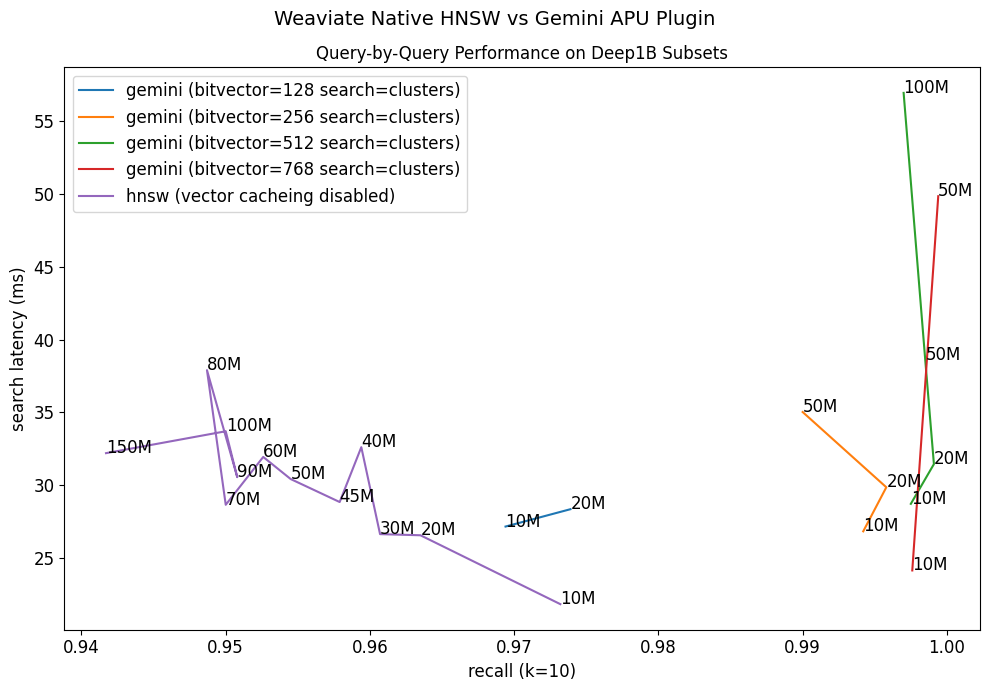

In [9]:
# Let's plot recall vs searchtime 
# showing dataset size trend for 
# each (index_type,bitsize) combo for gemini
# and just one line for hnsw.

# Get all plot points
all_points = [ (row["recall"], row["searchtime_ms"]) \
        for idx, row in recall_vs_searchtime[['recall','searchtime_ms']].iterrows() ]

# 
# Get plot lines for dataset size trends 
#

# groupby the experimental conditions
grps = recall_vs_searchtime.groupby(['idx','dset_size','bits','cacheing','search_type'])
recall_vs_searchTime_mean = grps.mean(numeric_only=True)  # choosing mean here because we dealt per query outliers earlier
recall_vs_searchTime_mean.reset_index(inplace=True)

# get the unique experiment parameters
idxs = recall_vs_searchTime_mean['idx'].unique()
bitses = recall_vs_searchTime_mean['bits'].unique()
cacheings = recall_vs_searchTime_mean['cacheing'].unique()
stypes = recall_vs_searchTime_mean['search_type'].unique()
print(stypes)
szs = recall_vs_searchTime_mean['dset_size'].unique()

show_clustered = True

plt.figure(figsize=(10, 7))

# loop through all parameter combinations to get a dset_size line
for idx in idxs: # iterate unique indexes
    for bits in bitses: # iterate all different bit sizes (hnsw=-1)
        for cacheing in cacheings: # iterate all different cache settings [gemini=False]
            for search_type in stypes: # iterate all search_types [hnsw='na']
            
                # get the plot points for dset_size trend
                line_df = recall_vs_searchTime_mean[ \
                    (recall_vs_searchTime_mean["idx"]==idx) & \
                    (recall_vs_searchTime_mean["bits"]==bits) & \
                    (recall_vs_searchTime_mean["cacheing"]==cacheing) & \
                    (recall_vs_searchTime_mean["search_type"]==search_type) ]         
                
                if line_df.shape[0]==0: continue # don't plot if there are no experiments yet

                # possibly filter for higher recall
                #line_df = line_df[ line_df['recall']>0.92 ]

                # sort by dset_size to plot that trend as a line
                line_df = line_df.sort_values(by=['dset_size'])

                # extract just the points of the line
                line_pts = [ (row['recall'], row['searchtime_ms'], \
                              row['dset_size'] ) for idx, row in line_df.iterrows() ]
                xs = [ pt[0] for pt in line_pts ]
                ys = [ pt[1] for pt in line_pts ]

                # need dset_size for line annotations
                dset_size = [ pt[2] for pt in line_pts ]

                # labels depend on the index, bitsize, and/or cacheing
                if idx=="gemini":
                    if show_clustered:
                        label = "%s (bitvector=%d search=%s)" % (idx, bits,search_type)
                    elif search_type=="flat":
                        label = "%s (bitvector=%d)" % (idx, bits)
                    else:
                        continue
                elif idx=="hnsw":
                    label = "%s (vector cacheing %s)" % (idx, "enabled" if cacheing else "disabled")
                else:
                    label = "%s" % idx

                # plot the line and annotation
                plt.plot( xs, ys, label=label )
                for pt in line_pts:
                    dset_size = pt[2]
                    if dset_size==10000: dset = '10K'
                    elif dset_size==1000000: dset = '1M'
                    elif dset_size==2000000: dset = '2M'
                    elif dset_size==5000000: dset = '5M'
                    elif dset_size==10000000: dset = '10M'
                    elif dset_size==20000000: dset = '20M'
                    elif dset_size==30000000: dset = '30M'
                    elif dset_size==40000000: dset = '40M'
                    elif dset_size==45000000: dset = '45M'
                    elif dset_size==50000000: dset = '50M'
                    elif dset_size==60000000: dset = '60M'
                    elif dset_size==70000000: dset = '70M'
                    elif dset_size==80000000: dset = '80M'
                    elif dset_size==90000000: dset = '90M'
                    elif dset_size==100000000: dset = '100M'
                    elif dset_size==150000000: dset = '150M'
                    else: dset = "na"

                    # custom data to nudge annotation text
                    off = (0,0)
                    if idx=="hnsw" and cacheing==True:
                        if dset=="1M":
                            off = (0.0, -3)
                        if dset=="2M":
                            off = (0.0, 1)
                        elif dset=="5M":
                            off = (0.003, -3)
                    elif idx=="hnsw" and cacheing==False:
                        if dset=="30M":
                            off = (-0.004, -2.5)
                        elif dset=="45M":
                            off = (-0.005, -1.8)
                        elif dset=="50M":
                            off = (-0.002, 0.5)
                        elif dset=="60M":
                            off = (-0.007, -4.0)
                        elif dset=="70M":
                            off = (-0.007, -4.0)
                        elif dset=="80M":
                            off = (-0.007, -4.0)
                        elif dset=="90M":
                            off = (-0.0011, 3.2)
                        elif dset=="100M":
                            off = (-0.0079, -3.0)
                        elif dset=="150M":
                            off = (-0.0079, -1.0)
                    elif idx=="gemini" and bits==768 and search_type=="flat":
                        if dset=="10K":
                            off = (-0.007,2)
                        elif dset=="10M":
                            off = (-0.007,0)
                        elif dset=="20M":
                            off = (0,-2.5)
                    elif idx=="gemini" and search_type=="clusters":
                        if dset=="1M":
                            off = (0.02, 1)
                        elif dset=="2M":
                            off = (-0.02, 0)
                        elif dset=="5M":
                            off = (-0.01, 1.5)
                        off = (0,0)
                    elif idx=="gemini" and bits==64:
                        if dset=="10K":
                            off = (0.002,0)
                    
                    off = (0.00,0)
                    plt.annotate( dset, (pt[0], pt[1]), fontsize=12, \
                                 xytext=(pt[0] + off[0], pt[1] + off[1]) )
                
plt.legend(loc=0, fontsize=12)
##plt.xlim(0.96, 1.0)
#plt.ylim(0, 40)
plt.xlabel("recall (k=10)", fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("search latency (ms)", fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle("Weaviate Native HNSW vs Gemini APU Plugin", fontsize=14)
plt.title("Query-by-Query Performance on Deep1B Subsets", fontsize=12 )
plt.tight_layout()
plt.savefig("results/plot-all.png",bbox_inches='tight')

In [10]:
# Look for the "Import" results files to get import elapsed time

# regular expression for just the import csvs
import_regex = ".*Import-(.*)__Benchmark(.*).csv"

f1_csvs = glob.glob( os.path.join("results", "fractals-1", "*.csv" ) )
apu11_csvs = glob.glob( os.path.join("results", "sv7-apu11", "*.csv" ) )
apu12_csvs = glob.glob( os.path.join("results", "sv7-apu12", "*.csv" ) )
prev_csvs = glob.glob( os.path.join("results", "previous", "*.csv" ) )
csvs = f1_csvs + apu11_csvs + apu12_csvs + prev_csvs

# exclude some files with known issues
exclusions = [ \
    "Import-sv7-apu11__BenchmarkDeep1B__sz_10000__gemini__bt_768____1680903585.581726.csv"
]    

# accumulate final results here
results = []

# iterate all the csvs
for csv in csvs:
    
    # ignore some files with known issues
    brk = False
    for exclusion in exclusions:       
        if csv.endswith(exclusion): brk=True
    if brk: continue
    
    # match filename via regex
    matches = re.match( import_regex, csv ) 
    if matches:
        
        machine = matches.groups()[0]
        #print(machine, csv)
        
        # parse the 'event' field for records added in this run
        df = pd.read_csv( csv ) 
        df['ev_0'] = \
            df.apply( lambda row:  row['event'].split()[0], axis=1 )
        df_added = df[ df['ev_0']=='added' ].copy()
        df_added['rec_start'] = \
            df_added.apply( \
                lambda row: int(row['event'].split()[1].split("/")[0]), axis=1 )
        min_rec = df_added['rec_start'].min()
        max_rec = df_added['rec_start'].max() + 1000 -1
        #print( min_rec, max_rec, df_added.columns )
        
        # parse the 'ts' field to get the elapsed time for import events only
        import_start = df[ df["ev_0"]=="end_schema_check"]
        ts_import_start = import_start.iloc[0, :]["ts"]
        import_end = df[ df["ev_0"]=="done"]
        ts_import_end = import_end.iloc[0, :]["ts"]
        
        # compute the total elapsed
        import_elapsed = (ts_import_end-ts_import_start)/(60.0*60.0) 
        
        # prepare a row for final dataframe
        result = {'machine':machine,\
                  'rec_start': min_rec, \
                  'rec_end': max_rec, \
                  'elapsed': import_elapsed, \
                  'rec_total': max_rec - min_rec + 1 }
        results.append(result)
     
# prepare a dataframe from all the computed results
df_results = pd.DataFrame(results)


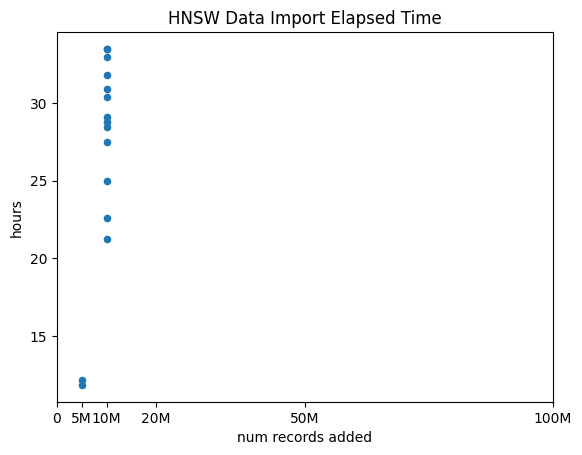

In [11]:
# Analyze and plot native HNSW import elapsed time

df_hnsw = df_results[ df_results["machine"]=="fractals-1"]
ax = df_hnsw.plot.scatter('rec_total','elapsed')
ax.set_xlabel("num records added")
ax.set_ylabel("hours")
ax.set_xticks([0,  5000000, 10000000, 20000000, 50000000, 100000000])
ax.set_xticklabels(['0', '5M', '10M', '20M', '50M', '100M'])
ax.set_title("HNSW Data Import Elapsed Time")
plt.savefig("hnsw_import_elapsed_time.png")

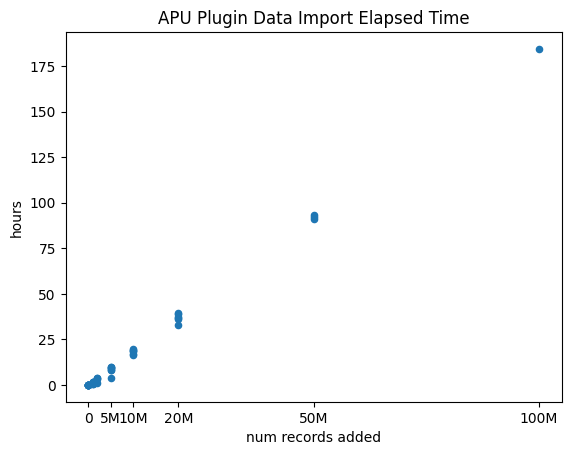

In [12]:
# Analyze and plot APU plugin import elapsed time

df_apu = df_results[ \
    (df_results["machine"]=="sv7-apu11") | \
    (df_results["machine"]=="sv7-apu12") ]         
ax = df_apu.plot.scatter('rec_total','elapsed')
ax.set_xlabel("num records added")
ax.set_ylabel("hours")
ax.set_xticks([0,  5000000, 10000000, 20000000, 50000000, 100000000])
ax.set_xticklabels(['0', '5M', '10M', '20M', '50M', '100M'])
ax.set_title("APU Plugin Data Import Elapsed Time")
plt.savefig("apu_import_elapsed_time.png")